<a href="https://colab.research.google.com/github/shino11/Tesis_Deteccion-de-ironia-y-casificacion-de-Polaridad-en-rese-as-de-usuarios-de-Trip-Advisor/blob/main/sgd_lstm1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [3]:
!pip install -U tensorflow==2.0
!pip install -U numpy==1.19.5
!pip install h5py==2.10.0

#!pip uninstall tensorflow
#!pip install tensorflow
#!pip uninstall numpy
#!pip install numpy
#!apt-get install python3.7

#import sys
#import tensorflow as tf

#tf.__version__
#!python3 ‐‐version
#print(sys.version)

#!pip show numpy tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  Corpus  Label             ID  \
0    GEN      1  GEN_sarc_0000   
1    GEN      1  GEN_sarc_0001   
2    GEN      1  GEN_sarc_0002   
3    GEN      1  GEN_sarc_0003   
4    GEN      1  GEN_sarc_0004   

                                          Quote Text  \
0  First off, That's grade A USDA approved Libera...   
1  watch it. Now you're using my lines. Poet has ...   
2  Because it will encourage teens to engage in r...   
3  Obviously you missed the point. So sorry the t...   
4  This is pure paranoia. What evidence do you ha...   

                                       Response Text  
0  Therefore you accept that the Republican party...  
1  More chattering from the peanut gallery? Haven...  
2  Yep, suppressing natural behavior is always th...  
3  I guess we all missed your point Justine, what...  
4  Evidence, I dont need no sticking evidence. Th...  
23460
(4692, 5)
4692
4692
total words embeddings is  400000 339251
[[14098  3371 13946 ...     0     0     0]
 [ 4233 52400  336

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 100)          33925200  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                14976     
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 33,940,242
Trainable params: 15,042
Non-trainable params: 33,925,200
_________________________________________________________________
None
Training...
Train on 3377 samples, validate on 376 samples
Epoch 1/16

Epoch 00001: val_loss improved from inf to 0.69718, saving model to best_model_lstm11.h5
3377/3377 - 11s - loss: 0.7066 - accuracy: 0.4905 - val_loss: 0.6972 - val_ac


Testing data
(939, 150) (939, 2)
939/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Testing data
(938, 150) (938, 2)
938/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Testing data
(938, 150) (938, 2)
938/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Testing data
(938, 150) (938, 2)
938/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

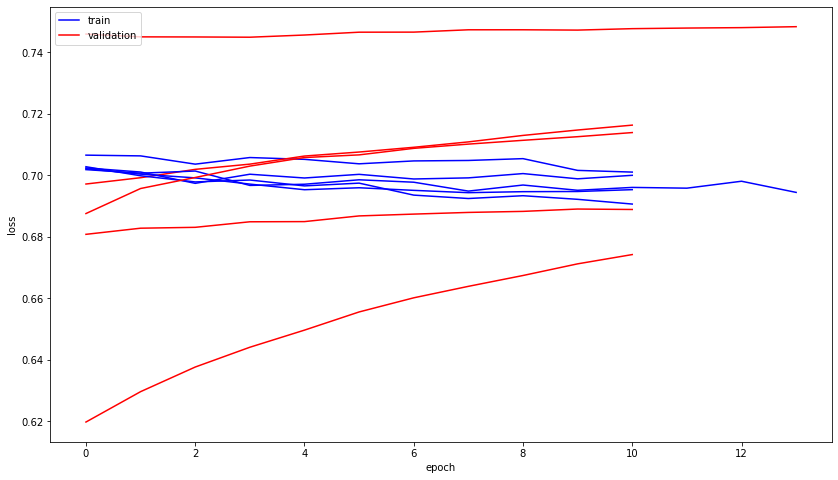

avg b_accuracy precision recall f1
0.4932005625368598
0.49655962567358625
0.4931785617780563
0.3965035789655577


In [1]:
import io
from builtins import print
import numpy as np
#import keras
import tensorflow as tf
import pandas as pd
#from keras import Model
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
#from tensorflow.core.protobuf import rewriter_config_pb2
import os
# from keras.engine.saving import model_from_json
# from keras.models import Sequential
# from keras.layers import Dense, Flatten, Lambda
# from keras.layers import LSTM, Input
# from keras.layers import Dense, Embedding, Reshape
# from keras.layers.wrappers import TimeDistributed
# from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
#from keras.utils.np_utils import to_categorical
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, balanced_accuracy_score, confusion_matrix
#from statsmodels.sandbox.distributions.examples.ex_mvelliptical import fig
from tensorflow.keras import Model
from tensorflow.keras.layers import Bidirectional
from tensorflow.python.keras.layers.core import Dropout, RepeatVector
from tensorflow.keras.layers import LSTM, Reshape
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
#from tensorflow.python.keras.engine.saving import model_from_json
from tensorflow.python.training.adam import AdamOptimizer
from tensorflow.keras import Input
#from tensorflow_core.python.keras.layers import concatenate, Concatenate, Bidirectional
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
#import tensorflow_addons as tfa

#class HLSTM:

#with tf.device('/gpu:0'):
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.models import load_model

EMBEDDING_DIM = 100
# MAX_NB_WORDS = 100000
text = []
labels = []

learning_rate = 0.00001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# optimizer = 'Adadelta'
#optimizer = 'Adam'
dropout = 0.6
neurons = 16
patience = 10
epochs = 16
batch_size = 128
folds = 5


def save_model(model, filename):
    model_json = model.to_json()
    with open(filename + '.model', "w") as json_file:
        json_file.write(model_json)
        json_file.close();
    model.save_weights(filename + ".weights")


# def load_model(filename):
#     json_file = open(filename + '.model', 'r')
#     loaded_model_json = json_file.read()
#     json_file.close()
#     # loaded_model = model_from_json(loaded_model_json)
#     # loaded_model.load_weights(filename + ".weights")
#     # return loaded_model;


def getEmbeddingLayer(EMBEDDING_DIM):
    embeddings_index = {}
    count = 0
    words = []
    #f = open('data/word_embeddings/glove.840B.300d.txt', encoding='utf-8', errors='ignore')
    #f = open('data/word_embeddings/glove.6B.100d.txt', encoding='utf-8')
    f = open('/content/drive/MyDrive/Colab Notebooks/TestCode/glove.6B.100d.txt')
    #f = open('word_embeddings/glove.6B.100d.txt')
    

    for line in f:
        values = line.split(' ')
        word = values[0]
        words.append(word)
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        count = count + 1;
    f.close()

    # fin = io.open('data/word_embeddings/GoogleNews-vectors-negative300.bin', 'r', encoding='utf-8', newline='\n',
    #               errors='ignore')
    # n, d = map(int, fin.readline().split())
    # for line in fin:
    #     tokens = line.rstrip().split(' ')
    #     word = tokens[0]
    #     words.append(word)
    #     embeddings_index[tokens[0]] = map(float, tokens[1:])
    #     count += 1
    # fin.close()

    tokenizer_obj = Tokenizer(num_words=len(words)) #MAX_NB_WORDS
    # tokenizer = Tokenizer(num_words=len(words))
    tokenizer_obj.fit_on_texts(words)
    word_index = tokenizer_obj.word_index
    vocab_size = len(word_index) + 1

    print("total words embeddings is ", count, len(word_index))
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i > vocab_size - 1:
            break
        else:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(input_dim=vocab_size,
                                output_dim=EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

    return tokenizer_obj, embedding_layer


def create_embedded_model(embedding_layer, num_classes, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM):
    input = Input(shape=(MAX_SEQUENCE_LENGTH,))
    emb_layer = embedding_layer(input)
    out1 = Bidirectional(LSTM(32, return_sequences=True, return_state=False, stateful=False, dropout=0.6), merge_mode = 'concat')(emb_layer)
    out1 = Bidirectional(LSTM(neurons, return_sequences=False, return_state=False, stateful=False, dropout=dropout), merge_mode='concat')(emb_layer)
    # crf = tfa.keras.layers.CRF(32)(out1)
    output = Dense(2, activation='sigmoid')(out1)
    model = Model(input, output)
    print(model.summary())
    return model;


# Start here

dataframe = pd.DataFrame()
# dataframe = pd.read_csv('./data/atis-intent.csv', encoding='ISO-8859-1', sep=',')
#dataframe = pd.read_csv('./data/dstc8.csv', encoding='ISO-8859-1', sep='^', engine='python')
#dataframe = pd.read_csv("./data/sgd single-domains/sgd_act_Flights.csv", encoding='ISO-8859-1', sep='^', engine='python')
#dataframe = pd.read_csv("data/sgd single-domains/sgd-act-prec1-Flights.csv", encoding='ISO-8859-1', sep='^', engine='python')
dataframe = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sarcasm_v2(0-1).csv", encoding='ISO-8859-1', sep=',', engine='python')
#dataframe = pd.read_csv("sarcasm_v2(0-1).csv", encoding='ISO-8859-1', sep=',', engine='python')

print(dataframe.head())
# dataframe = dataframe.replace(to_replace=r'\s,,\s', value=' ')
print(dataframe.size)

#cols = ['dialogue','text','label']
#cols = ['dialogue', 'text', 'prec_utt', 'prec_intent', 'label']
cols = ['Corpus', 'Label', 'ID', 'Quote Text', 'Response Text']
dataframe.columns = cols
#D = dataframe.loc[:, 'dialogue']
#X = dataframe.loc[:, 'text']
#A = dataframe.loc[:, 'prec_utt']
#B = dataframe.loc[:, 'prec_intent']
#Y = dataframe.loc[:, 'label']

#D = dataframe.loc[:, 'Corpus']
Y = dataframe.loc[:, 'Label']
#B = dataframe.loc[:, 'ID']
A = dataframe.loc[:, 'Quote Text']
X = dataframe.loc[:, 'Response Text']

print(dataframe.shape)
#X = X.reshape((len(X),1))

X_featured = []
for i in range(X.count()):
    X_featured.append(X[i] + ' ' + A[i])
  #X_featured.append(X[i] + ' ' + A[i] + ' ' + B[i])
X_featured = np.reshape(X_featured, X.shape)
#print(X_featured.shape)
#print(dataframe.shape)
# X = X.reshape((len(X),1))
print(X.count())
print(Y.count())

MAX_SEQUENCE_LENGTH = max([len(s.split()) for s in X])
tokenizer, embedding_layer = getEmbeddingLayer(EMBEDDING_DIM)

sequences_x = tokenizer.texts_to_sequences(X_featured) #X_featured
# sequences_a = tokenizer.texts_to_sequences(A)
# sequences_b = tokenizer.texts_to_sequences(B)
# #sequences_a2 = tokenizer.texts_to_sequences(A2)
# #sequences_b2 = tokenizer.texts_to_sequences(B2)
# print(sequences_x)
# print(sequences_a)
# print(sequences_b)
#dd = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data = pad_sequences(sequences_x, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating="post")
# aa = pad_sequences(sequences_a, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
# bb = pad_sequences(sequences_b, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
# #aa2 = pad_sequences(sequences_a2, maxlen=MAX_SEQUENCE_LENGTH)
# #bb2 = pad_sequences(sequences_b2, maxlen=MAX_SEQUENCE_LENGTH)
# print(xx)
# print(aa)
# print(bb)
# d = np.transpose(d)
# data = xx * aa * bb
print(data)
uniques, ids = np.unique(Y, return_inverse=True)
y_train = tf.keras.utils.to_categorical(ids, len(uniques))
# y_train = np.reshape(y_train, (Y.count(),len(uniques)))
# y_train = keras.utils.to_categorical(Y,Y.count())
print(uniques)
print(y_train)
# y_train = np.array(y_train.shape[1])
# df = pd.DataFrame(data=y_train.data)
# y_train = np.asarray(Y)
print("Training data")
print(data.shape, y_train.shape)

# np.random.seed(1)
# y = np.random.randint(0, len(num_classes)-1, y_train.shape)
# y = y[np.where(y.sum(axis=1) != 0)[0]]
# y_new = LabelEncoder().fit_transform([''.join(str(l)) for l in y])
# print(y_new)
# seed = 7346
# np.random.seed(seed)
count = 0
precision_list = list()
recall_list = list()
accuracy_list = list()
f1_list = list()
fig, ax = plt.subplots(figsize=(14, 8))
historyl = list()

# cross validation
kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=0)
#optimizer = AdamOptimizer(learning_rate=0.0001)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
for train, test in kfold.split(data, Y):
    # x_train, x_test, Y_train, Y_test = train_test_split(data, y_train, test_size=0.8, random_state=0)
    print(data[train].shape, y_train[train].shape)
    count += 1
    print('Fold: {0}'.format(count))
    model = create_embedded_model(embedding_layer, len(uniques), MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)

    # adad = tf.train.AdadeltaOptimizer()
    # adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=optimizer , metrics=['accuracy'])
    print('Training...')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
    mc = ModelCheckpoint('best_model_lstm1'+str(count)+'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    # model.fit(np.reshape(data[train],(-1,data[train].shape[0],data[train].shape[1])), y_train[train], epochs=50, batch_size=batch_size, verbose=1, steps_per_epoch=20)  # 50 , steps_per_epoch=20
    history = model.fit(data[train], y_train[train], validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[es, mc])  # 50 , steps_per_epoch=20
    historyl.append(history)
    # save_model(model, "data/model")
    saved_model = load_model('best_model_lstm1'+str(count)+'.h5')
    # HASTA AQUÃ  OK------------------------------------------------------------

    # TESTING
    print()
    print("Testing data")
    print(data[test].shape, y_train[test].shape)

    score, acc = saved_model.evaluate(data[test], y_train[test], verbose=1)
    print("acc: ", acc)
    print("Accuracy: {0:.2%}".format(acc))
    print('Test score:', score)
    y_predict = saved_model.predict(data[test])
    # y_predict = np.argmax(y_predict, axis=1)
    print(y_predict.shape)
    labels_pred = np.argmax(np.round(y_predict),axis=1)
    labels_train = np.argmax(y_train[test], axis=1)
    print(labels_train)
    print(labels_pred)
    #print(y_train[test], np.round(y_predict))
    accur = accuracy_score(y_train[test], np.round(y_predict))
    # print(roc_auc_score(Y[test], y_predict, average='macro'))
    print('Test accuracy:', accur)
    #print(confusion_matrix(np.argmax(y_train[test],axis=1), np.round(y_predict).argmax(axis=1)))
    b_acc = balanced_accuracy_score(labels_train, labels_pred)
    recall = recall_score(labels_train, labels_pred, average='weighted')
    precision = precision_score(labels_train, labels_pred, average='weighted')
    f1 = f1_score(labels_train, labels_pred, average='weighted')
    print('Test b_acc:', b_acc)
    print('Test precision:', precision)
    print('Test recall:', recall)
    print('Test f1:', f1)
    accuracy_list.append(b_acc)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    print(history.history.keys())
    plt.plot(history.history['loss'], color='blue')
    plt.plot(history.history['val_loss'], color='red')
    #plt.title(str(count))
    #plt.show()
    #fig.savefig(str(count)+'.png', bbox_inches='tight', pad_inches=0)

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

#plt.boxplot(accuracy_list)
#plt.show()
#fig.savefig('box.png', bbox_inches='tight', pad_inches=0)
print('avg b_accuracy precision recall f1')
# print('avg b_accuracy {0}'.format(np.average(accuracy_list)))
# print('avg precision {0}'.format(np.average(precision_list)))
# print('avg recall {0}'.format(np.average(recall_list)))
# print('avg f1 {0}'.format(np.average(f1_list)))
print(np.average(accuracy_list))
print(np.average(precision_list))
print(np.average(recall_list))
f1_final = np.average(f1_list)
print(f1_final)

fig.savefig('loss-lstm (optimizer='+str(optimizer)+', dropout='+str(dropout)+', neurons='+str(neurons)+', patience='+str(patience)+', epocas='+str(epochs)+', batch_size='+str(batch_size)+', folds='+str(folds)+', f1=' + str(f1_final)+ ', learning_rate'+ str(learning_rate)+').png', bbox_inches='tight', pad_inches=0)

#plt.figure()